# Table of Contents
 <p>

In [2]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
car = cv2.cvtColor(cv2.imread("../../vehicles_smallset/cars1/1.jpeg"), cv2.COLOR_BGR2RGB)
noncar = cv2.cvtColor(cv2.imread("../../non-vehicles_smallset/notcars1/extra810.jpeg"), cv2.COLOR_BGR2RGB)

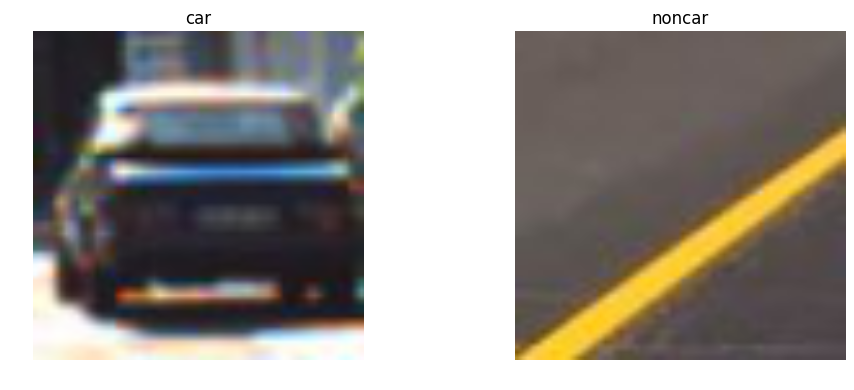

In [60]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].imshow(car); axes[0].set_title("car")
axes[1].imshow(noncar); axes[1].set_title("noncar")
[axe.axis('off') for axe in axes]
plt.savefig("./example_images/car_noncar.jpg", dpi=50)
plt.tight_layout()
plt.show()

In [5]:
import matplotlib.image as mpimg
from skimage import io
import glob
from skimage.feature import hog
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.svm import SVC # for rbf
from sklearn.metrics import accuracy_score

In [6]:
def cal_hog_feature(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    """Extract HOG feature from one color channel"""
    features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, feature_vector=feature_vec)
    return features

def extract_hog_features(image, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True, hog_color="RGB"):
    """Extract HOG features from colorspace you specify"""
    if hog_color != 'RGB':
        if hog_color == 'HSV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        elif hog_color == 'LUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
        elif hog_color == 'HLS':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        elif hog_color == 'YUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        elif hog_color == 'YCrCb':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(image)

    hog_features = []
    for channel in range(feature_image.shape[2]):
        hog_features.extend(cal_hog_feature(feature_image[:,:,channel],
                            orient, pix_per_cell, cell_per_block,
                            vis=viz, feature_vec=feature_vec))

def extract_features(images, hog_color='RGB', spatial_color="LUV", hist_color="HLS", spatial_size=(32, 32),
                        hist_bins=32, orient=9,
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    """Extract features from HOG, color binning, and histogram of color space.
       You could choose features you wanna use.

       # Returns:
           features(ndarray): extracted features (1-dimensional array)
    """
    features = []
    for image in images:
        file_features = []
        if spatial_feat == True:
            spatial_features = bin_spatial(image, size=spatial_size, color=spatial_color)
            file_features.append(spatial_features)
        if hist_feat == True:
            hist_features = color_hist(image, nbins=hist_bins, color=hist_color)
            file_features.append(hist_features)
        if hog_feat == True:
            hog_features = extract_hog_features(image, orient, pix_per_cell, cell_per_block, hog_color=hog_color)
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    return np.array(features)

def bin_spatial(image, size=(32, 32), color="RGB"):
    """binning image of specified color space"""
    if color != 'RGB':
        if color == 'HSV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        elif color == 'LUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
        elif color == 'HLS':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        elif color == 'YUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        elif color == 'YCrCb':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(image)
    return cv2.resize(feature_image, size).ravel()

def color_hist(image, nbins=32, bins_range=(0, 256), color="RGB"):
    """convert RGB Image to specified color space histogram"""
    if color != 'RGB':
        if color == 'HSV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        elif color == 'LUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
        elif color == 'HLS':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        elif color == 'YUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        elif color == 'YCrCb':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(image)
    channel1_hist = np.histogram(feature_image[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(feature_image[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(feature_image[:,:,2], bins=nbins, range=bins_range)
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    return hist_features


In [8]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, cspace='RGB', orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        # Append the new feature vector to the features list
        features.append(hog_features)
    # Return list of feature vectors
    return features

In [9]:
_, hog_car_0 = get_hog_features(car[:, :, 0], 18, 8, 3, vis=True)
_, hog_car_1 = get_hog_features(car[:, :, 1], 18, 8, 3, vis=True)
_, hog_car_2 = get_hog_features(car[:, :, 2], 18, 8, 3, vis=True)
_, hog_noncar_0 = get_hog_features(noncar[:, :, 0], 18, 8, 3, vis=True)
_, hog_noncar_1 = get_hog_features(noncar[:, :, 1], 18, 8, 3, vis=True)
_, hog_noncar_2 = get_hog_features(noncar[:, :, 2], 18, 8, 3, vis=True)

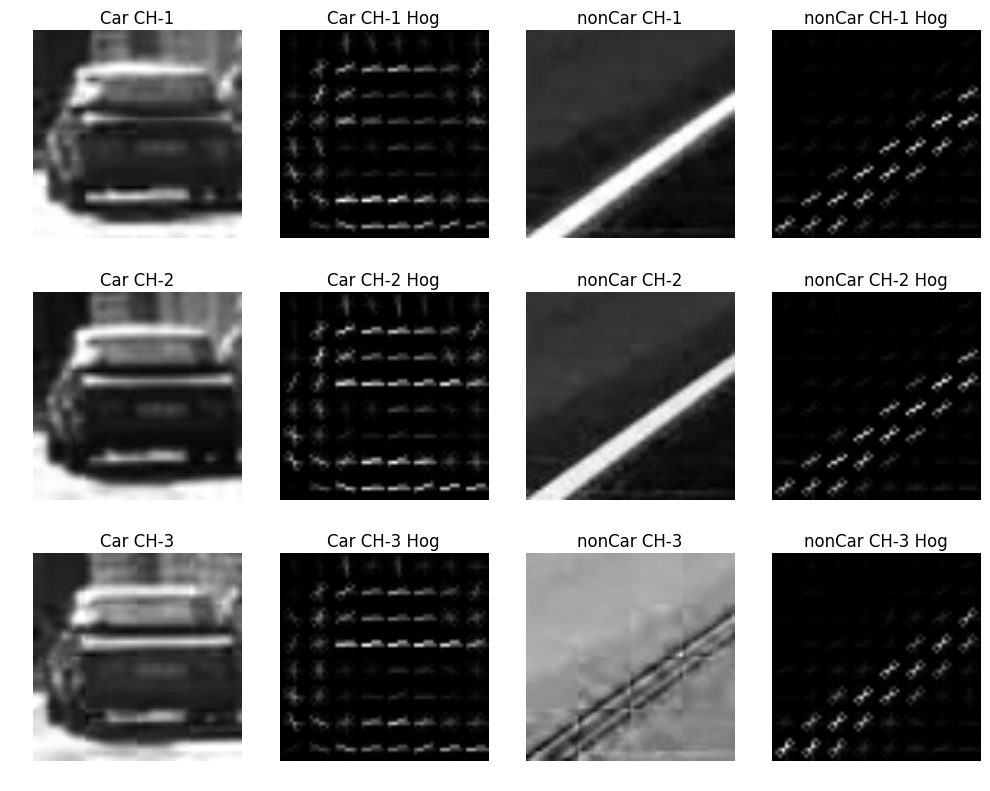

In [37]:
fig, axes = plt.subplots(3, 4, figsize=(10, 8))
axes[0, 0].imshow(car[:, :, 0]); axes[0, 0].set_title("Car CH-1")
axes[0, 1].imshow(hog_car_0); axes[0, 1].set_title("Car CH-1 Hog")
axes[1, 0].imshow(car[:, :, 1]); axes[1, 0].set_title("Car CH-2")
axes[1, 1].imshow(hog_car_1); axes[1, 1].set_title("Car CH-2 Hog")
axes[2, 0].imshow(car[:, :, 2]); axes[2, 0].set_title("Car CH-3")
axes[2, 1].imshow(hog_car_2); axes[2, 1].set_title("Car CH-3 Hog")

axes[0, 2].imshow(noncar[:, :, 0]); axes[0, 2].set_title("nonCar CH-1")
axes[0, 3].imshow(hog_noncar_0); axes[0, 3].set_title("nonCar CH-1 Hog")
axes[1, 2].imshow(noncar[:, :, 1]); axes[1, 2].set_title("nonCar CH-2")
axes[1, 3].imshow(hog_noncar_1); axes[1, 3].set_title("nonCar CH-2 Hog")
axes[2, 2].imshow(noncar[:, :, 2]); axes[2, 2].set_title("nonCar CH-3")
axes[2, 3].imshow(hog_noncar_2); axes[2, 3].set_title("nonCar CH-3 Hog")
[ax.axis("off") for axe in axes for ax in axe]
fig.tight_layout()
plt.gray()
plt.savefig("./example_images/features.jpg", dpi=50)
plt.show()

In [1]:
#!/user/bin/env python3
import time
import pickle
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from skimage import io
import glob
from skimage.feature import hog
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.svm import SVC # for rbf
from sklearn.metrics import accuracy_score
from scipy.ndimage.measurements import label
from util import *

In [8]:
def slide_window(image, x_start_stop=[None, None], y_start_stop=[None, None],
                 xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = image.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = image.shape[0]

    window_list = []
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    rate = 1/2
    xy_window_list = [[200, 170, int(yspan*rate), yspan, 0, xspan],
                      [150, 120, int(yspan*rate*6 / 4), yspan-int(yspan*rate*rate*rate), 0, xspan],
                      [120, 110, int(yspan*rate*6 / 4), yspan-int(yspan*rate*rate), 0, xspan],
                      [120, 96, int(yspan*rate*rate*rate), yspan-int(yspan*rate), 0, xspan],
                      [84, 64, 0, int(yspan*rate*rate), 0, xspan]]

    for xy_window in xy_window_list:
        nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
        ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))

        nx_windows = np.int((xy_window[5] - xy_window[4]) / nx_pix_per_step) - 1
        ny_windows = np.int((xy_window[3] - xy_window[2]) / ny_pix_per_step) - 1

        for ys in range(ny_windows):
            for xs in range(nx_windows):
                startx = xs * nx_pix_per_step + x_start_stop[0] + xy_window[4]
                endx = startx + xy_window[0]
                starty = ys * ny_pix_per_step + y_start_stop[0] + xy_window[2]
                endy = starty + xy_window[1]
                window_list.append(((startx, starty), (endx, endy)))
    return window_list

def draw_boxes(image, bboxes, color=(0, 0, 255), thick=6):
    new_image = image.copy()
    for bbox in bboxes:
        cv2.rectangle(new_image, bbox[0][0], bbox[0][1], color, thick)
    return new_image

def add_heat(heatmap, bbox_list, value=1):
    for box in bbox_list:
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += value
    return heatmap

def apply_threshold(heatmap, threshold):
    heatmap[heatmap <= threshold] = 0
    return heatmap

def search_windows(image, windows, svc, scaler, hog_color="RGB", hog_channel="ALL",
                   spatial_size=(32, 32), spatial_color="RGB", hist_color="HLS", hist_feat=True,
                   spatial_feat=True, orient=9, cell_per_block=3):
    on_windows = []
    for window in windows:
        test_img = cv2.resize(image[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))
        features = extract_feature(test_img, hog_color=hog_color, hog_channel=hog_channel, spatial_feat=spatial_feat,
                                    spatial_size=spatial_size, spatial_color=spatial_color, hist_color=hist_color,
                                    hist_feat=hist_feat, orient=orient, cell_per_block=cell_per_block)
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        prediction = svc.predict(test_features)
        if prediction == 1:
            if svc.decision_function(test_features)[0] > 0.3:
                on_windows.append([window, svc.decision_function(test_features)[0]])
    return on_windows

def draw_labeled_bboxes(img, labels):
    bbox_list = []
    for car_number in range(1, labels[1]+1):
        nonzero = (labels[0] == car_number).nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        bbox_list.append(bbox)
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    return img, bbox_list

def main():
    scaler = np.load("scaler.npz")
    X_scaler = StandardScaler()
    X_scaler.mean_, X_scaler.scale_ = scaler["mean"], scaler["scale"]
    with open("svm.pkl", mode="rb") as f:
        svc = pickle.load(f)

    cap = cv2.VideoCapture("project_video.mp4")
    heatmap = None
    ex_bbox_list = []
    exex_bbox_list = []
    exexex_bbox_list = []
    exexexex_bbox_list = []
    index=0
    while(1):
        if index >= 100 and index =< 105
        ret, image = cap.read()
    #for image in glob.glob("./test_images/*.jpg"):
        image = cv2.imread(image)
        index+=1
        heatmap = np.zeros_like(image)
        print("index", index)
        converted_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        windows = slide_window(converted_image, x_start_stop=[None, None], y_start_stop=[400, image.shape[0]-200],
                    xy_window=(240, 160), xy_overlap=(0.9, 0.9))
        bboxes = search_windows(converted_image, windows, svc, X_scaler, hog_color="YCrCb", hog_channel="ALL",
                                spatial_size=(16, 16), spatial_color="YCrCb", hist_color="YCrCb",
                                spatial_feat=True, orient=18, cell_per_block=2)
        
        if bboxes:
            heatmap = add_heat(heatmap, np.array(bboxes)[:, 0], value=2)
        if ex_bbox_list:
            heatmap = add_heat(heatmap, ex_bbox_list, value=2)
        if exex_bbox_list:
            heatmap = add_heat(heatmap, exex_bbox_list, value=2)
        if exexex_bbox_list:
            heatmap = add_heat(heatmap, exexex_bbox_list, value=1)
        if exexexex_bbox_list:
            heatmap = add_heat(heatmap, exexexex_bbox_list, value=1)
        """
        heatmap = apply_threshold(heatmap, threshold=6)
        labels = label(heatmap)
        exexexex_bbox_list = exexex_bbox_list
        exexex_bbox_list = exex_bbox_list
        exex_bbox_list = ex_bbox_list
        window_img, ex_bbox_list = draw_labeled_bboxes(image, labels)
        """
        
       # out.write(window_img)

        #window_img = draw_boxes(image, bboxes, color=(0, 0, 255), thick=6)
        cv2.imwrite("./example_images/heatmap" + str(index) + ".jpg", heatmap)
    cap.release()

In [9]:
main()

index 1
index 2
index 3
index 4
index 5
index 6
